# Benchmark Runner
After the prep work is done you can run the benchmark. First, some basic configuration work.

In [1]:
from remotemanager import Dataset
from remotemanager.transport import rsync, scp

from time import sleep
from os.path import join

from remotemanager import Logger
Logger.path = 'benchmark_remotemanager_log'
Logger.level = 'debug'

computer = "fugaku"
computer = "hokusai"
computer = 'archer2'

indir = "inp"
natoms = 54  # number of atoms in a molecule

# Small System to Compute
geom = "2CzPN_2"

# Large Systems to Compute
geoms = ["2CzPN_14", "2CzPN_18", "2CzPN_22", "2CzPN_26",
         "2CzPN_30", "2CzPN_34", "2CzPN_38", "2CzPN_42",
         "2CzPN_50", "2CzPN_58", "2CzPN_66", "2CzPN_74",
         "2CzPN_82", "2CzPN_90"
        ]

In [2]:
%load_ext remotemanager

Setup your computer.

In [3]:
transport = None

if computer == "hokusai":
    from remotecomputer.hokusai import Hokusai
    url = Hokusai()
    url.key = "Q22460"
    url.conda = "remote"
    # Default mpi/omp
    url.mpi = 1
    url.omp = 1
    url.elapse = "0:30:00"
    url.path_to_bigdft = "/home/wddawson/binaries/bdft"
    remote_dir = join("runs", "2023", "benchmark-tn")
    
    # For scanning the MPI/OMP choices
    mpi_omp = [(1, 40), (2, 20), (4, 10), (8, 5), (5, 8)]
    
    # Parameters for the large calculations
    large_mpi = 64
    large_omp = 10
    large_elapse = "4:00:00"
elif computer == "fugaku":
    from remotecomputer.fugaku import Fugaku
    url = Fugaku(user="u10035")
    url.key = "ra000009"
    url.mpi = 1
    url.omp = 1
    url.elapse = "00:30:00"
    url.path_to_bigdft = join("/home", url.key.value, "data", 
                              url.user, "binaries", "bdft")
    remote_dir = join("/home", url.key.value, "data",
                      url.user, "runs", "2023", "benchmark-tn")

    # For scanning the MPI/OMP choices
    mpi_omp = [(1, 48), (2, 24), (4, 12), (8, 6), (12, 4)]
    
    # Parameters for the large calculations
    large_mpi = 1024
    large_omp = 6
    large_elapse = "1:00:00"
elif computer == 'archer2':
    from remotecomputer.archer2 import archer2
    
    url = archer2(user='lbeal', 
                  passfile = '~/.archerpass', 
                  keyfile = '~/.ssh/id_ed25519_archer2',
                  python = 'python3')
    url.mpi = 1
    url.omp = 1
    url.walltime = "00:30:00"
    url.nodes = 1
    url.queue = 'standard'
    url.qos = 'standard'
    
    # url.modules = ['mkl']

    url.extra = """
module load cray-python
module swap PrgEnv-cray PrgEnv-gnu
module load mkl    

source /work/e572/e572/shared/build_cray/bigdft/bigdftvars.sh
export BIGDFT_MPIRUN='srun --hint=nomultithread --distribution=block:block'
export OMP_PLACES=cores
export FUTILE_PROFILING_DEPTH=0
"""    
    
    remote_dir = '/work/e572/e572/shared/bench_feb2023'

    # For scanning the MPI/OMP choices
    mpi_omp = [(128, 1), (64, 2), (32, 4), (16, 8), (8, 16)]
    
    transport = scp(url)

In [4]:
# set transport to rsync if not overridden

if transport is None:
    transport = rsync(url)

In [5]:
# validate that the url is working
url.cmd('ls')

bench_backup
buildrc_from_desk
from_archer
jpserver-81974-open.html
jpserver-81974.json
jupyter_cookie_secret
kernel-ea70d0f1-d53a-47d7-abe9-e7a061b6d6bb.json
manager_run_test

A routine that runs a calculation using the correct parameters for benchmarking.

In [6]:
def treat_system(sname, mpi, omp, indir=indir, linear=False):
    from BigDFT.IO import read_pdb
    from BigDFT.Inputfiles import Inputfile
    from BigDFT.Calculators import SystemCalculator
    from os.path import join
    
    # System
    with open(join(indir, sname + ".pdb")) as ifile:
        sys = read_pdb(ifile)
    
    # Input
    inp = Inputfile()
    inp.set_xc("PBE")
    inp.set_hgrid(0.5)
    inp.set_rmult(coarse=5.0, fine=7.0)
    inp.set_psp_nlcc()
    
    if linear:
        inp["import"] = "linear"
        inp["perf"] = {"check_sumrho": 0, "check_overlap": 0}
        inp["lin_general"] = {"charge_multipoles": 0, "output_mat": 0}
    
    # Compute
    calc = SystemCalculator(skip=True)
    
    # Determine the run name
    run_name = sname + "_" + str(mpi) + "_" + str(omp)
    log = calc.run(sys=sys, input=inp, name=run_name)

## Cubic Single Node Performance
The first benchmark checks the single node performance using a few combinations of threads and mpi ranks.

In [7]:
single_ds = Dataset(function = treat_system,
                    url = url, 
                    transport = transport,
                    extra_files_send=[indir],
                    dbfile="single_db_" + computer)

Add runs with each parameter.

In [8]:
for comb in mpi_omp:
    args = {"sname": geom, "mpi": comb[0], "omp": comb[1]}
    single_ds.append_run(arguments = args, mpi=comb[0], omp=comb[1],
                         remote_dir=remote_dir)

appended run runner-0
appended run runner-1
appended run runner-2
appended run runner-3
appended run runner-4


In [9]:
single_ds.run(dry_run=False)

assessing run for runner dataset-82da90fc-runner-0... checks passed, running
assessing run for runner dataset-4cba68bc-runner-1... checks passed, running
assessing run for runner dataset-c9dc2b0b-runner-2... checks passed, running
assessing run for runner dataset-f768eadf-runner-3... checks passed, running
assessing run for runner dataset-bdea54e8-runner-4... checks passed, running


In [10]:
single_ds.is_finished

checking remotely for finished runs


[False, False, False, False, False]

In [11]:
single_ds.run_cmds
while not single_ds.all_finished:
    print('not finished, sleeping')
    sleep(120)

checking remotely for finished runs
not finished, sleeping
checking remotely for finished runs
not finished, sleeping
checking remotely for finished runs


Fetch the time to solution data.

In [12]:
url.mpi = 1
url.omp = 1
url.elapse = "0:10:00"
db = "single_fetch_" + computer

In [13]:
%%execute_remotely url=url transport=transport remote_dir=remote_dir dbfile=db : mpi_omp=mpi_omp sname=geom
from yaml import load, SafeLoader
data = {}
for r in mpi_omp:
    run_name = sname + "_" + str(r[0]) + "_" + str(r[1])
    with open("time-" + run_name + ".yaml") as ifile:
        full = load(ifile, Loader=SafeLoader)
    data[run_name] = {"time": full["WFN_OPT"]["Classes"]["Total"][1]}

return data

appended run runner-0
assessing run for runner dataset-bd7ed470-runner-0... checks passed, running
checking remotely for finished runs


In [14]:
magic_dataset.fetch_results()
times = magic_dataset.results[0]

checking remotely for finished runs


Plot.

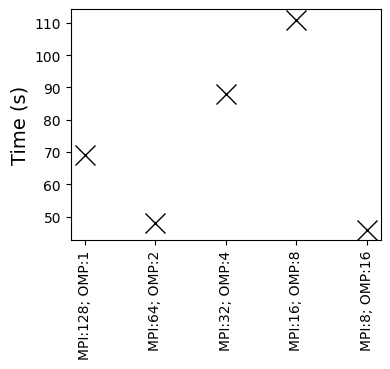

In [15]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
axs.plot([x["time"] for x in times.values()] , 'kx', markersize=14)
axs.set_ylabel("Time (s)", fontsize=14)
axs.set_xticks(range(len(list(times))))
axs.set_xticklabels(["MPI:" + str(comb[0]) + 
                     "; OMP:" + str(comb[1]) 
                     for comb in mpi_omp], rotation=90)
pass

## Linear Scaling Calculations
We will now switch to the linear scaling mode. We will run calculations of various size on a reasonable sized partition, and examine the performance.

In [ ]:
LVC_set = Dataset(function = treat_system,
                  url = url, dbfile="scale_db_" + computer)
url.elapse = large_elapse

In [ ]:
for g in geoms:
    args = {"sname": g, "mpi": large_mpi, "omp": large_omp, "linear": True}
    LVC_set.append_run(arguments = args, remote_dir=remote_dir,
                       mpi=large_mpi, omp=large_omp)

In [ ]:
LVC_set.run()

In [ ]:
while not single_ds.all_finished:
    sleep(120)

Fetch the times.

In [ ]:
url.mpi = 1
url.omp = 1
url.elapse = "0:10:00"
db = "scale_fetch_" + computer

In [ ]:
%%execute_remotely url=url remote_dir=remote_dir dbfile=db : geoms=geoms mpi=large_mpi omp=large_omp
from yaml import load, SafeLoader
data = {}
for g in geoms:
    run_name = g + "_" + str(mpi) + "_" + str(omp)
    with open("time-" + run_name + ".yaml") as ifile:
        full = load(ifile, Loader=SafeLoader)
    data[run_name] = {"time": full["WFN_OPT"]["Classes"]["Total"][1]}

return data

In [ ]:
magic_dataset.fetch_results()
times = magic_dataset.results[0]

Plot the time vs. number of atoms.

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
nats = [int(x.split("_")[-1])*54 for x in geoms]
minutes = [times[x + "_" + str(large_mpi) + 
                 "_" + str(large_omp)]["time"]/60 for x in geoms]
axs.plot([(m/a) * large_mpi*large_omp 
          for m, a in zip(minutes, nats)] , 
         'kx', markersize=14, label="Hokusai")
axs.set_ylabel("CPU Minutes per Atom", fontsize=14)
axs.set_xticks(range(len(list(times))))
axs.set_xticklabels(nats, rotation=90)
axs.set_xlabel("Number of Atoms", fontsize=14)
axs.legend()
fig.tight_layout()
fig.savefig("benchmark.png", dpi=300)
pass